## Modeling timeseries data in MXNet: using LSTM to predict AWS spot instance price

@sunilmallya

@jrhunt

MXNet cheat sheet: https://s3.amazonaws.com/aws-bigdata-blog/artifacts/apache_mxnet/apache-mxnet-cheat.pdf

Dataset: https://raw.githubusercontent.com/sunilmallya/mxnet-notebooks/master/python/tutorials/data/p2-east-1b.csv

### Recurrent Neural Networks (RNN)

<img src="https://camo.githubusercontent.com/89a1cc7342d324ca30e45025bb278572f3f114d2/687474703a2f2f6b617270617468792e6769746875622e696f2f6173736574732f726e6e2f64696167732e6a706567"/>

<p style="text-align: center; font-size: 22px;"><em>h<sub>t</sub> = activation(X<sub>t</sub>W<sub>x</sub> + h<sub>t-1</sub>W<sub>h</sub> )</em></p>

LSTMs -- Long Short Term Memory
<img src="https://camo.githubusercontent.com/5a4faf272952795d0011b147dc8bb0a3a7095cb3/687474703a2f2f646565706c6561726e696e672e6e65742f7475746f7269616c2f5f696d616765732f6c73746d5f6d656d6f727963656c6c2e706e67">

UnRolling LSTMs

<img src="https://camo.githubusercontent.com/a90144b7e3d10d3b5a267cb617bb90b938cb048a/687474703a2f2f636f6c61682e6769746875622e696f2f706f7374732f323031352d30382d556e6465727374616e64696e672d4c53544d732f696d672f524e4e2d756e726f6c6c65642e706e67"?>


In [ ]:
pip install mxnet
pip install numpy
pip install matplotlib
pip install pandas


In [5]:
# load the

!wget https://raw.githubusercontent.com/sunilmallya/mxnet-notebooks/master/python/tutorials/data/p2-east-1b.csv

--2017-10-05 18:59:38--  https://raw.githubusercontent.com/sunilmallya/mxnet-notebooks/master/python/tutorials/data/p2-east-1b.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 465850 (455K) [text/plain]
Saving to: ‘p2-east-1b.csv’

100%[======================================>] 465,850     --.-K/s   in 0.04s   

2017-10-05 18:59:38 (10.7 MB/s) - ‘p2-east-1b.csv’ saved [465850/465850]



In [11]:
import pandas
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt

%matplotlib inline

df = pandas.read_csv('p2-east-1b.csv', usecols=[0,4], names=['date', 'cost'])

df.head()

,date,cost
0,2017-05-08 21:42:56+00:00,0.2500
1,2017-05-08 21:41:01+00:00,0.2402
2,2017-05-08 21:40:05+00:00,0.2414
3,2017-05-08 21:42:56+00:00,0.2500
4,2017-05-08 21:41:01+00:00,0.2402


In [8]:
import dateutil.parser

values = df.values[::-1]

ticks = map(dateutil.parser.parse, values[:,0])
dataset = values[:,1]
dataset.shape

(7183,)

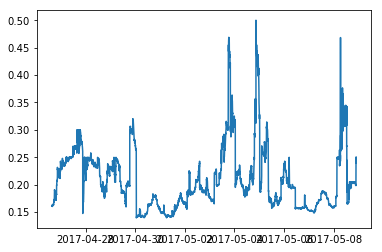

In [9]:
plt.plot(ticks, dataset)

In [13]:
# Tx = Tx-1, Tx-2 ; Window size = 2


from sklearn.preprocessing import MinMaxScaler

dataset = np.reshape(dataset, (len(dataset), 1))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(dataset)

dataset[:5],  scaled_dataset[:5]

(array([[0.162],
        [0.1623],
        [0.1616],
        [0.161],
        [0.1613]], dtype=object), array([[ 0.06241331],
        [ 0.06324549],
        [ 0.06130374],
        [ 0.05963939],
        [ 0.06047157]]))

In [16]:
# align the data

seq_len = 2

x = scaled_dataset
y = scaled_dataset[: ,[-1]]

x[:5], y[:5]

dataX = []; dataY = []

for i in range(0, len(y)-seq_len):
    _x = x[i: i+seq_len]
    _y = y[i+seq_len]
    dataX.append(_x)
    dataY.append(_y)
    
dataX[0], dataY[0]

# Tx0, Tx1 => Tx2 
# Tx1, Tx2 => Tx3

(array([[ 0.06241331],
        [ 0.06324549]]), array([ 0.06130374]))

In [18]:
dataX[1], dataY[2]

(array([[ 0.06324549],
        [ 0.06130374]]), array([ 0.06047157]))

In [47]:
# Define Itertors 

#split the data
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) -  train_size

batch_size = 32

trainX, testX = np.array(dataX[:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[:train_size]), np.array(dataY[train_size:])


train_iter = mx.io.NDArrayIter(data=trainX, label=trainY, 
                               batch_size=batch_size, shuffle=True)

val_iter = mx.io.NDArrayIter(data=testX, label=testY, 
                               batch_size=batch_size, shuffle=False)

trainX.shape

(5026, 2, 1)

In [48]:
# Lets build the network
data = mx.sym.var("data")
data = mx.sym.transpose(data, axes=(1,0,2))

# T N C -- Time Steps/ Seq len; N - Batch Size, C - dimensions in the hidden state

'''
Long-Short Term Memory (LSTM) network cell.

Parameters:	
num_hidden (int) – Number of units in output symbol.
prefix (str, default ‘lstm_‘) – Prefix for name of layers (and name of weight if params is None).
params (RNNParams, default None) – Container for weight sharing between cells. Created if None.
forget_bias (bias added to forget gate, default 1.0.) – Jozefowicz et al. 2015 recommends setting this to 1.0

'''

lstm1 = mx.rnn.LSTMCell(num_hidden=5, prefix='lstm1')
lstm2 = mx.rnn.LSTMCell(num_hidden=10, prefix='lstm2')

L1, states = lstm1.unroll(length=seq_len, inputs=data, merge_outputs=True, layout="TNC")
L2, L2_states = lstm2.unroll(length=seq_len, inputs=L1, merge_outputs=True, layout="TNC")

L2_reshape = mx.sym.reshape(L2_states[0], shape=(-1, 0), reverse=True)  # (T*N, 10 -- num_hidden lstm2)
fc = mx.sym.FullyConnected(L2_reshape, num_hidden=1, name='fc')
net = mx.sym.LinearRegressionOutput(data=fc, name="softmax")

#mx.viz.plot_network(net) #, shape=(1,2,2))

In [57]:
# Training

import logging
logging.getLogger().setLevel(logging.DEBUG)

num_epochs = 2
model = mx.mod.Module(symbol=net, context=mx.cpu(0))

model.fit(train_data=train_iter, eval_data=val_iter,
        optimizer="adam",
        optimizer_params={'learning_rate': 1E-3},
        eval_metric="mse",
        num_epoch=num_epochs
         )


INFO:root:Epoch[0] Train-mse=0.036224
INFO:root:Epoch[0] Time cost=0.166
INFO:root:Epoch[0] Validation-mse=0.021374
INFO:root:Epoch[1] Train-mse=0.015755
INFO:root:Epoch[1] Time cost=0.151
INFO:root:Epoch[1] Validation-mse=0.003693


In [58]:
test_pred = model.predict(val_iter).asnumpy()
#type(test_pred)
print np.mean((test_pred - testY)**2)

test_plot = scaler.inverse_transform(test_pred)
test_plot[:5], testY[:5]

0.00370868180762


(array([[ 0.24493368],
        [ 0.21718703],
        [ 0.19813988],
        [ 0.19741414],
        [ 0.19685887]], dtype=float32), array([[ 0.14618585],
        [ 0.14174757],
        [ 0.14008322],
        [ 0.13453537],
        [ 0.13730929]]))

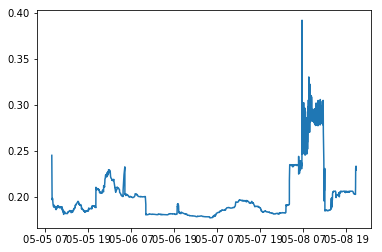

In [59]:
plt.plot(ticks[train_size+seq_len:], test_plot)

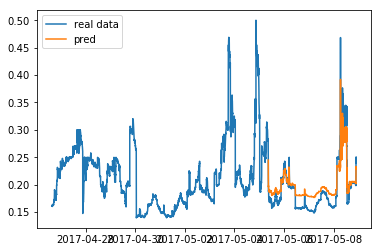

In [60]:

t_plot = np.empty_like(dataset)
t_plot[:] = np.nan
t_plot[len(trainY): -seq_len] = test_plot 
plt.plot(ticks, dataset, label="real data")
plt.plot(ticks, t_plot, label= "pred")

plt.legend()